# CANARIE 2017 -- Analysis of the survey

This notebook is the first draft to analyse the results from [CANARIE]()

## Preparation and filtering of the dataset

In [10]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv


In [71]:
# Load dataset
df = pd.read_csv('./dataset/2017 Cdn Research Software Developer Survey - Public data.csv')
# Number of row == number of participants
len(df.index)

114

### Date submitted
The variable 'Date submitted' is set up when the participant finish the survey. If the row on this column is empty, it means the participant did not finish the survey. These participants are removed, even if they have submitted partial answers.

In [81]:
#df['Date submitted'].unique
df = df[df['Date submitted'].notnull()]
# Getting the number of row from the reduced dataframe
len(df.index)


102

### Countries
A question asked the participants in which country they were currently working and specify when it was not Canada.


In [25]:
pd.crosstab(df['In which country do you work?'], columns='Countries')

col_0,Countries
In which country do you work?,
Canada,110
Other,4


There is only 4 others. Which are only one from Japan, 2 from USA and one from UK.  

In [28]:
pd.crosstab(df['In which country do you work? [Other]'], columns='Other countries')


col_0,Other countries
In which country do you work? [Other],
Japan,1
USA,2
uk,1


As this answer are not useful for CANARIE, because these people are not working in Canada, they are removed from the dataset.

In [43]:
df = df.loc[df['In which country do you work?'] != 'Other']
# Getting the number of row from the reduced dataframe
len(df.index)

110

### Writing software as part of the work

One question asked if the participants write software for research as part of their work.

In [44]:
pd.crosstab(df['Do you write software for research as part of your job?'], columns='Writing software')


col_0,Writing software
Do you write software for research as part of your job?,
No,13
Yes,97


13 answered 'No'. This survey, being about researcher that write codes, they are removed from the dataset

In [45]:
df = df.loc[df['Do you write software for research as part of your job?'] == 'Yes']
# Getting the number of row from the reduced dataframe
len(df.index)

97

## Univariate analysis



### Languages

The survey was in French and in English. The option choose by the participant was collected. It is possible then to see the proportion of participants that answered the survey in French or in English

In [41]:
pd.crosstab(df['Start language'], columns='Language')


col_0,Language
Start language,
en,96
fr,14


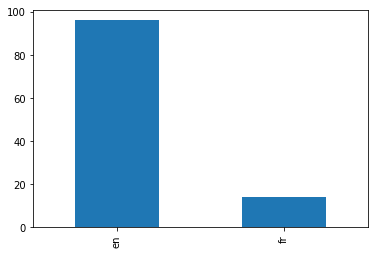

In [42]:
df['Start language'].value_counts().plot(kind='bar')


### Education level
The question asked the level of education

In [63]:
# Recode the column as categorical variable
df['What is the highest level of education you have attained?'] = df['What is the highest level of education you have attained?'].astype('category')

# Reorder the factors to match the education level
df['What is the highest level of education you have attained?'].cat.reorder_categories(['Some University',
                                                                                         'College Diploma',
                                                                                         'Bachelors Degree',
                                                                                         'Masters Degree',
                                                                                         'Doctorate'],
                                                                                       inplace=True)
pd.crosstab(df['What is the highest level of education you have attained?'], columns='Education level')

col_0,Education level
What is the highest level of education you have attained?,
Some University,5
College Diploma,4
Bachelors Degree,18
Masters Degree,26
Doctorate,44


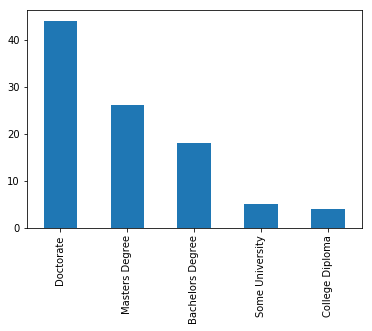

In [65]:
df['What is the highest level of education you have attained?'].value_counts().plot(kind='bar', sort_columns=True)


### Discipline

In which discipline the participants obtained their highest qualification. The answers were from the [NSERC codes](http://www.nserc-crsng.gc.ca/Help-Aide/Codes-ListeDeCodes_Eng.asp). 
However, it is the option 'Other', followed by a freetext option, which is the most chosen.
Therefore, before plotting it, we need to clean and merge these answers with the NESRC ones. 

#### Discipline -- Other



In [93]:
df['In which discipline is your highest academic qualification? [Other]'] = df['In which discipline is your highest academic qualification? [Other]'].str.lower()
pd.crosstab(df['In which discipline is your highest academic qualification? [Other]'], columns='Disciplines -- Other')


col_0,Disciplines -- Other
In which discipline is your highest academic qualification? [Other],
biochemistry/bioinformatics,1
bioinformatics,2
bioinformatique,1
biophysics,1
computer,1
computer & information science,1
computer engineering,2
computer engineering/science,1
computer science,2


In [82]:
pd.crosstab(df['In which discipline is your highest academic qualification?'], columns='Disciplines')


col_0,Disciplines
In which discipline is your highest academic qualification?,
Agricultural engineering,1
Applied mathematics,5
Artificial intelligence,6
Astronomy and astrophysics,2
Biochemistry,2
Biomedical engineering,2
Chemical engineering,3
Earth science,2
Electrical and electronic engineering,5


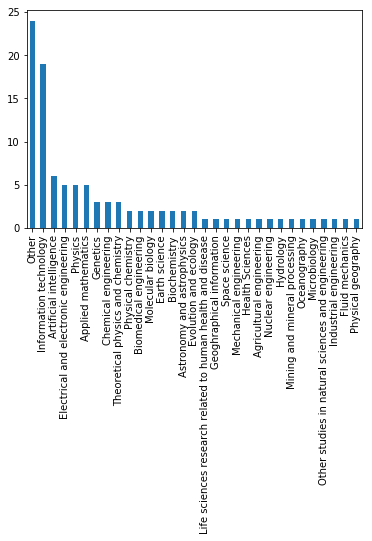

In [83]:
df['In which discipline is your highest academic qualification?'].value_counts().plot(kind='bar', sort_columns=True)
